# Predict cell types

In this notebook, we leverage existing mouse gastrulation data and manually annotated cell types to predict cell type annotations for the rabbit.

Automated annotations approaches use the entire transcriptomic profile to predict cell types at a per-cell basis.

Here we used SingleR (Aran et al. 2019), an automated annotation method which uses the correlation across differentially expressed genes to determine cell type identities. Details of the method can be found [here](http://bioconductor.org/books/release/SingleRBook/).

In [6]:
devtools::reload(pkgload::inst("scrabbitr"))

ℹ Reloading attached scrabbitr



In [1]:
suppressPackageStartupMessages(library(SingleR))
suppressPackageStartupMessages(library(scrabbitr))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(viridis))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggrepel))
                               
set.seed(44)
options(repr.plot.width=18, repr.plot.height=8)

out_path <- "../data-out/celltype_annotation/"

In [200]:
devtools::reload(pkg = "../scrabbitr/", quiet = FALSE)


ℹ Reloading attached scrabbitr


Attaching package: ‘scrabbitr’


The following object is masked _by_ ‘.GlobalEnv’:

    plotAnnotationAlluvium




## Load data

In [43]:
# Load rabbit data
r_data <- scrabbitr::loadRabbitData("../data-in/rabbit/")
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

In [44]:
r_genes <- read.table("../data-in/rabbit/genes.tsv",sep="\t")
rowData(r_data) <- r_genes
rownames(r_data) <- r_genes$gene_name

In [45]:
# Load mouse data
m_data <- readRDS("../data-in/mouse/integrated_sce.rds")
m_data

class: SingleCellExperiment 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(0):
reducedDimNames(0):
altExpNames(0):

In [46]:
m_meta <- read.table("../data-in/mouse/meta.tsv",sep="\t")
head(m_meta)

cell   sample stage stage.mapped stage.collapsed stage.mapped.collapsed
1 cell_1 1      E6.5  E6.5         E6.5            E6.5                  
2 cell_2 1      E6.5  E6.5         E6.5            E6.5                  
3 cell_5 1      E6.5  E6.5         E6.5            E6.5                  
4 cell_6 1      E6.5  E6.5         E6.5            E6.5                  
5 cell_8 1      E6.5  E6.5         E6.5            E6.5                  
6 cell_9 1      E6.5  E6.5         E6.5            E6.5                  
  somite_count tube_name    tube_name_corrected celltype        
1 Undetermined Undetermined Undetermined        Epiblast        
2 Undetermined Undetermined Undetermined        Primitive Streak
3 Undetermined Undetermined Undetermined        ExE ectoderm    
4 Undetermined Undetermined Undetermined        Epiblast        
5 Undetermined Undetermined Undetermined        Epiblast        
6 Undetermined Undetermined Undetermined        Epiblast        
  celltype.extended celltype.descendant celltype.descendant.somites
1 Epiblast          Epiblast            Epiblast                   
2 Primitive Streak  Primitive Streak    Primitive Streak           
3 ExE ectoderm      ExE ectoderm        ExE ectoderm               
4 Epiblast          Epiblast            Epiblast                   
5 Epiblast          Epiblast            Epiblast                   
6 Epiblast          Epiblast            Epiblast                   
  doub.density cluster cluster.sub celltype.clustering
1 0.0431142    7       5           Epiblast           
2 1.1297133    7       6           Primitive Streak   
3 0.1121205    1       6           ExE ectoderm       
4 1.2547088    7       2           Epiblast           
5 1.3457586    7       1           Epiblast           
6 1.1463686    7       1           Epiblast

In [182]:
m_genes <- read.table("../data-in/mouse/genes.tsv",sep="\t")
rowData(m_data) <- m_genes
rownames(m_data) <- m_genes$gene_name

In [47]:
m_data$celltype <- m_meta[,"celltype.clustering"]

In [14]:
# Load macaque data - Yang 2021
mf_data <- scrabbitr::loadYang2021("../data-in/datasets/Yang_2021/")
mf_data

class: SingleCellExperiment 
dim: 19367 7194 
metadata(0):
assays(2): counts logcounts
rownames(19367): ENSMFAG00000044637 ENSMFAG00000039056 ...
  ENSMFAG00000003950 ENSMFAG00000022236
rowData names(2): ensembl_id gene_name
colnames(7194): WT_d10_b2_AAACGAATCAGGGATG WT_d10_b2_AAAGAACTCCTGGTCT
  ... WT_d12_b2_TTTGGAGAGTCATGGG WT_d12_b2_TTTGGAGCATGGGATG
colData names(4): celltype stage batch sizeFactor
reducedDimNames(2): PCA UMAP
altExpNames(0):

In [29]:
rownames(mf_data) <- rowData(mf_data)[,"gene_name"]

In [3]:
# Load human data - Tyser 2020
hs_data <- scrabbitr::loadTyser2020("../data-in/datasets/Tyser_2020/")

In [38]:
# Load one-to-one orthologs
oc_mm_one2one <- read.table("../data-in/orthologs/mmusculus.tsv",sep="\t",col.names=c("oc","mm"))
oc_mf_one2one <- read.table("../data-in/orthologs/mfascicularis.tsv",sep="\t",header=TRUE, col.names=c("oc","mf"))
oc_hs_one2one <- read.table("../data-in/orthologs/hsapiens.tsv",sep="\t",header=TRUE, col.names=c("oc","hs"))

In [49]:
# Get rabbit, mouse, human one-to-one orthologs
library(biomaRt)

mart = useMart("ensembl", dataset = paste0("mmusculus","_gene_ensembl"))

mm_hs_homologs = getBM(attributes = c("ensembl_gene_id", "external_gene_name",
                                      paste0("hsapiens","_homolog_ensembl_gene"),
                                      paste0("hsapiens","_homolog_associated_gene_name"),
                                      paste0("hsapiens","_homolog_orthology_type")),
                       filters = "ensembl_gene_id",
                       values = rownames(m_data),
                       mart = mart)

mm_hs_one2one <- scrabbitr::filterSharedFeatures(rownames(hs_data),"hsapiens",mm_hs_homologs)
colnames(mm_hs_one2one) <- c("mm","hs")
head(mm_hs_one2one)


mm_mf_homologs = getBM(attributes = c("ensembl_gene_id", "external_gene_name",
                                      paste0("mfascicularis","_homolog_ensembl_gene"),
                                      paste0("mfascicularis","_homolog_associated_gene_name"),
                                      paste0("mfascicularis","_homolog_orthology_type")),
                       filters = "ensembl_gene_id",
                       values = rownames(m_data),
                       mart = mart)

mm_mf_one2one <- scrabbitr::filterSharedFeatures(rownames(mf_data),"mfascicularis",mm_mf_homologs)
colnames(mm_mf_one2one) <- c("mm","mf")

head(mm_hs_one2one)

Ensembl site unresponsive, trying uswest mirror



mm                 hs    
1 ENSMUSG00000000037 SCML2 
2 ENSMUSG00000000134 TFE3  
3 ENSMUSG00000000194 GPR107
4 ENSMUSG00000000223 DRP2  
5 ENSMUSG00000000247 LHX2  
6 ENSMUSG00000000266 MID2

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'mf_data' not found


## Predicting cell types in the rabbit

In [ ]:
m_train <- trainSingleR(ref = m_data[rm_one2one$query,],
                              labels = m_data$celltype,
                              de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)

saveRDS(model_train,paste0(out_path,"mouse_trained_aggr.rds"))

In [ ]:
# Load pre-trained model
m_train <- readRDS(paste0(out_path,"mouse_trained_aggr.rds"))

In [ ]:
r_predict <- classifySingleR(test = r_data[rm_one2one$ref,],
                                 trained = m_train)

saveRDS(r_predict,paste0(out_path,"singler_rabbit_predicted.rds"))

## Predicting cell types in macaque

### Training on mouse and rabbit data

In [34]:
# Get one-to-one orthologs across species
oc_mm_mf_one2one <- merge(oc_mf_one2one, mm_mf_one2one,by="mf")
head(oc_mm_mf_one2one)

mf                 oc                 mm                
1 ENSMFAG00000000025 ENSOCUG00000007927 ENSMUSG00000036223
2 ENSMFAG00000000028 ENSOCUG00000013009 ENSMUSG00000075478
3 ENSMFAG00000000034 ENSOCUG00000013068 ENSMUSG00000017311
4 ENSMFAG00000000037 ENSOCUG00000006469 ENSMUSG00000059923
5 ENSMFAG00000000038 ENSOCUG00000009295 ENSMUSG00000036499
6 ENSMFAG00000000039 ENSOCUG00000024446 ENSMUSG00000020644

In [35]:
# Prepare data
r_temp <- r_data[oc_mm_mf_one2one$oc,]
rownames(r_temp) <- oc_mm_mf_one2one$mf

m_temp <- m_data[oc_mm_mf_one2one$mm,]
rownames(m_temp) <- oc_mm_mf_one2one$mf

In [36]:
# Train SingleR
ocmm_train_mf <- trainSingleR(ref = list(oc=r_temp, mm=m_temp), 
    labels = list(r_data$celltype, m_data$celltype),
                             de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)
saveRDS(ocmm_train_mf,paste0(out_path,"oc_mm_train_mf.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 itera

In [17]:
ocmm_train_mf <- readRDS(paste0(out_path,"oc_mm_train_mf.rds"))

In [39]:
mf_predict_ocmm <- classifySingleR(test = mf_data[oc_mm_mf_one2one$mf,],
                                 trained = ocmm_train_mf)
saveRDS(mf_predict_ocmm,paste0(out_path,"mf_predict_ocmm_train.rds"))

In [18]:
mf_predict_ocmm <- readRDS(paste0(out_path,"mf_predict_ocmm_train.rds"))

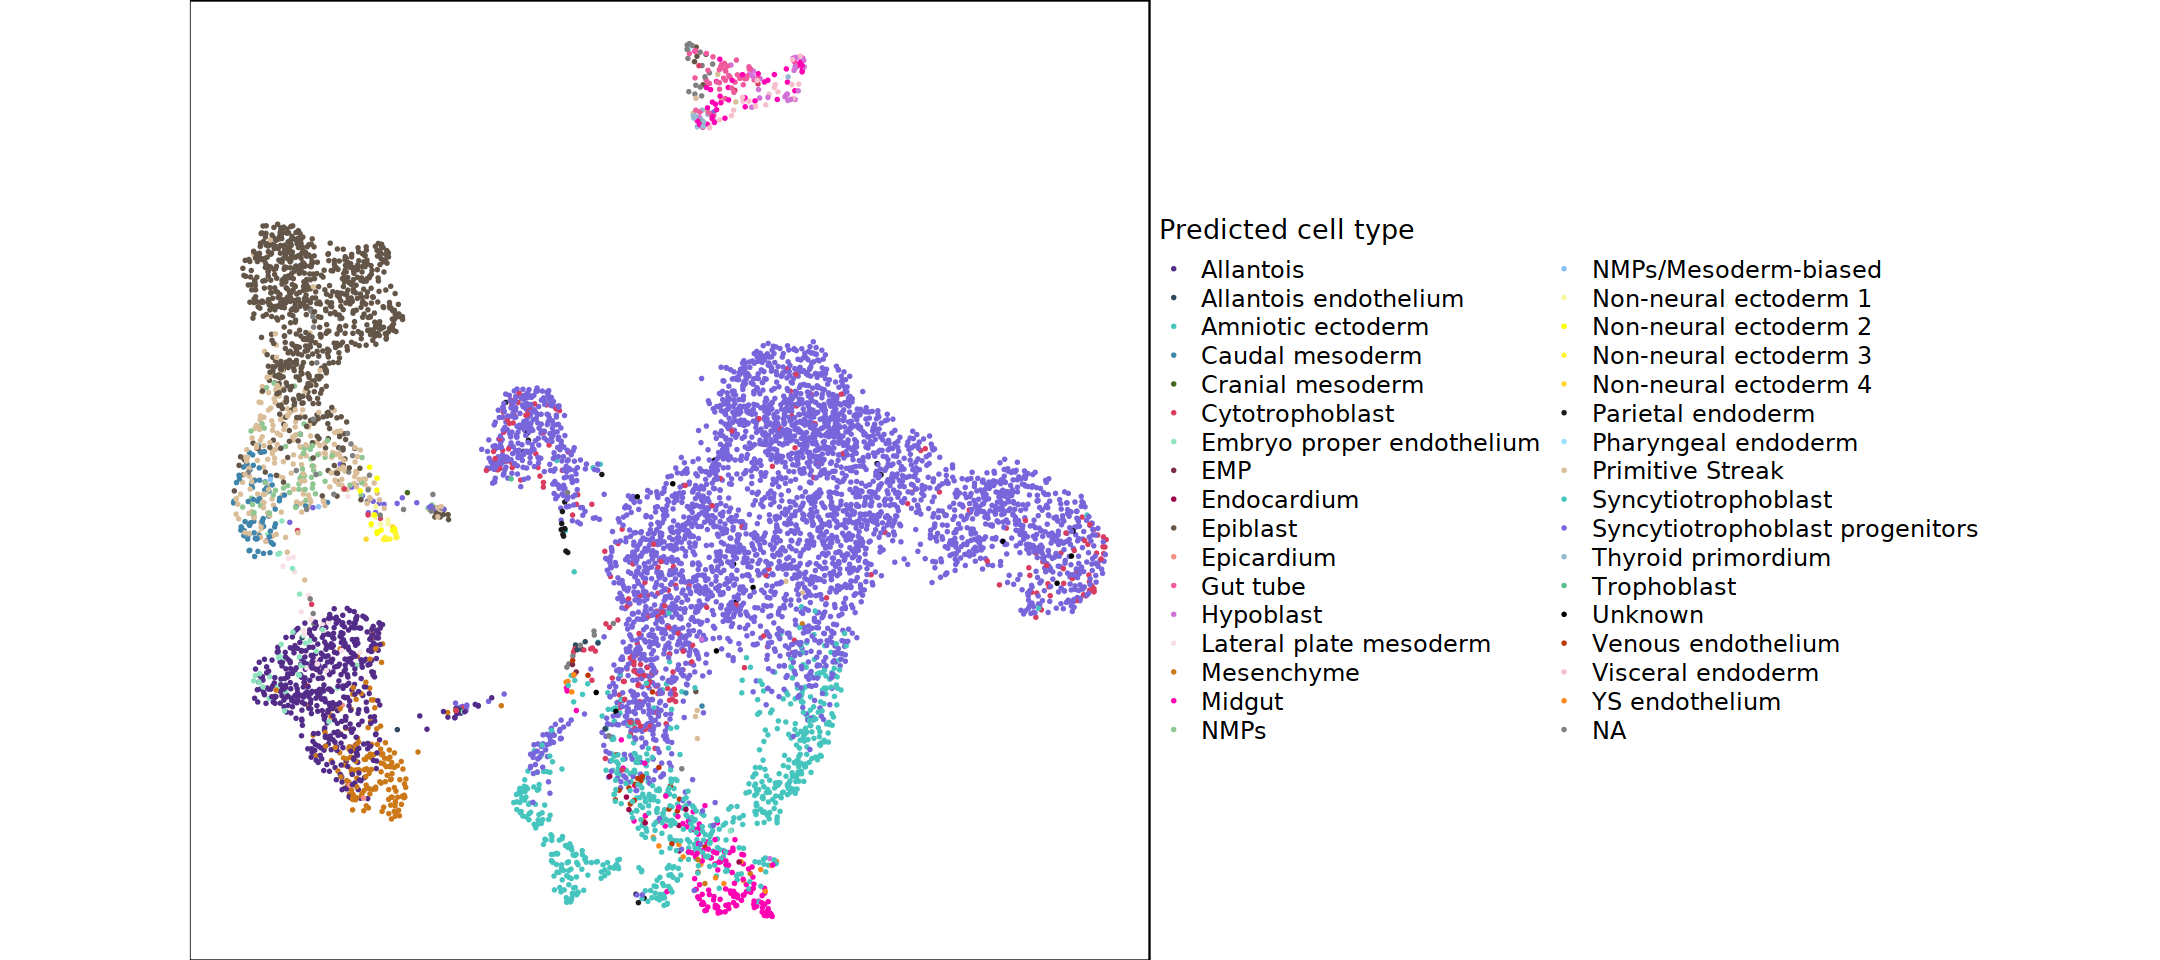

In [26]:
mf_data$predicted_celltype <- mf_predict_ocmm$orig.results$oc$pruned.labels

p1 <- ggcells(mf_data, aes_string(x="UMAP.1",y="UMAP.2",colour="celltype")) +
geom_point_rast(size=0.5) + 
scale_colour_discrete(name="Cell type") + theme_void() +
theme(axis.title = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
          aspect.ratio = 1)

p2 <- ggcells(mf_data, aes_string(x="UMAP.1",y="UMAP.2",colour="predicted_celltype")) + 
geom_point(size=0.5) +
scale_colour_manual(values=scrabbitr::celltype_colours,
                    limits=force,name="Predicted cell type") +
theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
          aspect.ratio = 1) 

#p <- grid.arrange(p1,p2, nrow=1)
p2

In [277]:
ggsave("../plots/predict_celltypes/mf_day14_predicted_oc_train.pdf",p2,width=10,height=6)
ggsave("../plots/predict_celltypes/mf_day14_original.pdf",p1,width=10,height=6)

Warning message:
“Removed 20 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”


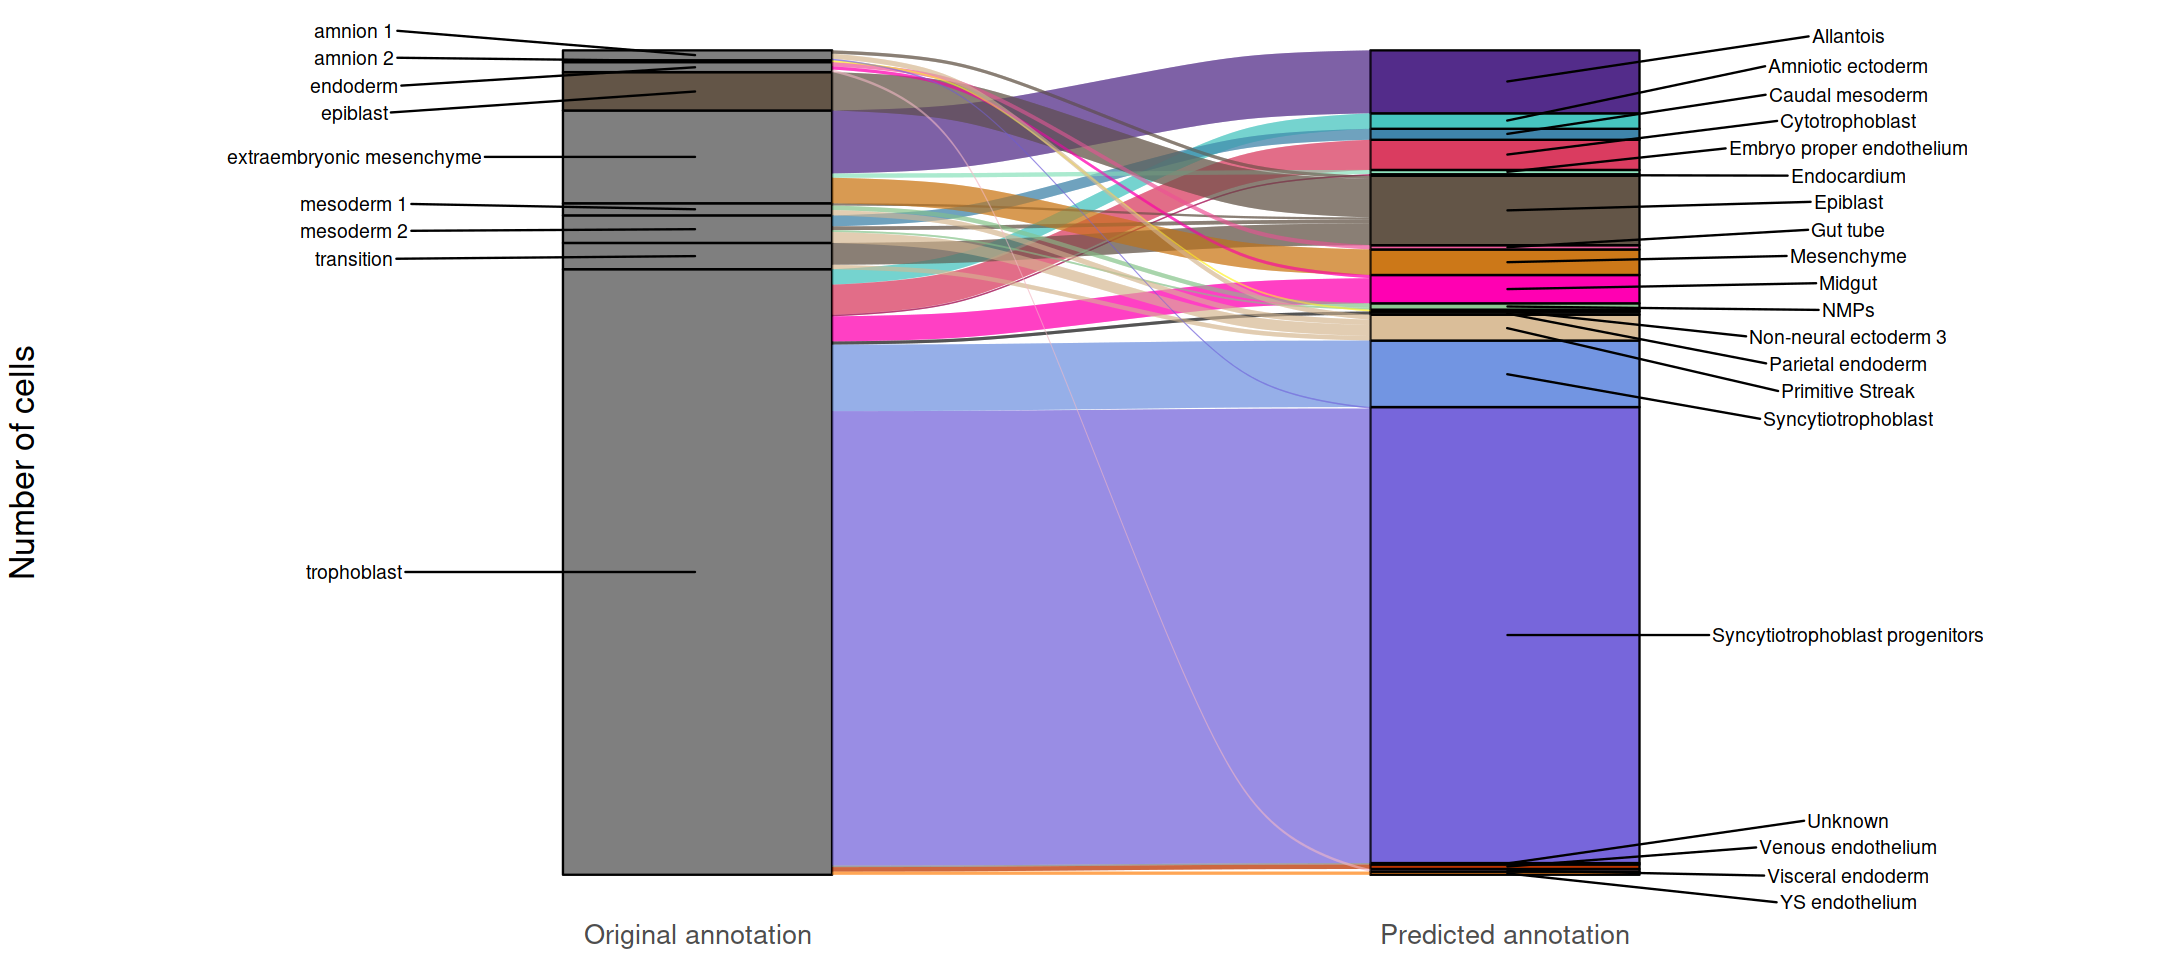

In [285]:
p <- scrabbitr::plotAnnotationAlluvium(mf_data[,mf_data$stage=="d14"],
                                       "celltype", "predicted_celltype",ncell_thresh=7,nudge=0.425)
p
#ggsave("../plots/predict_celltypes/Yang_2021_day14_alluvial.pdf",p,dpi=300, width=12, height=8)

### Explore predictions

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



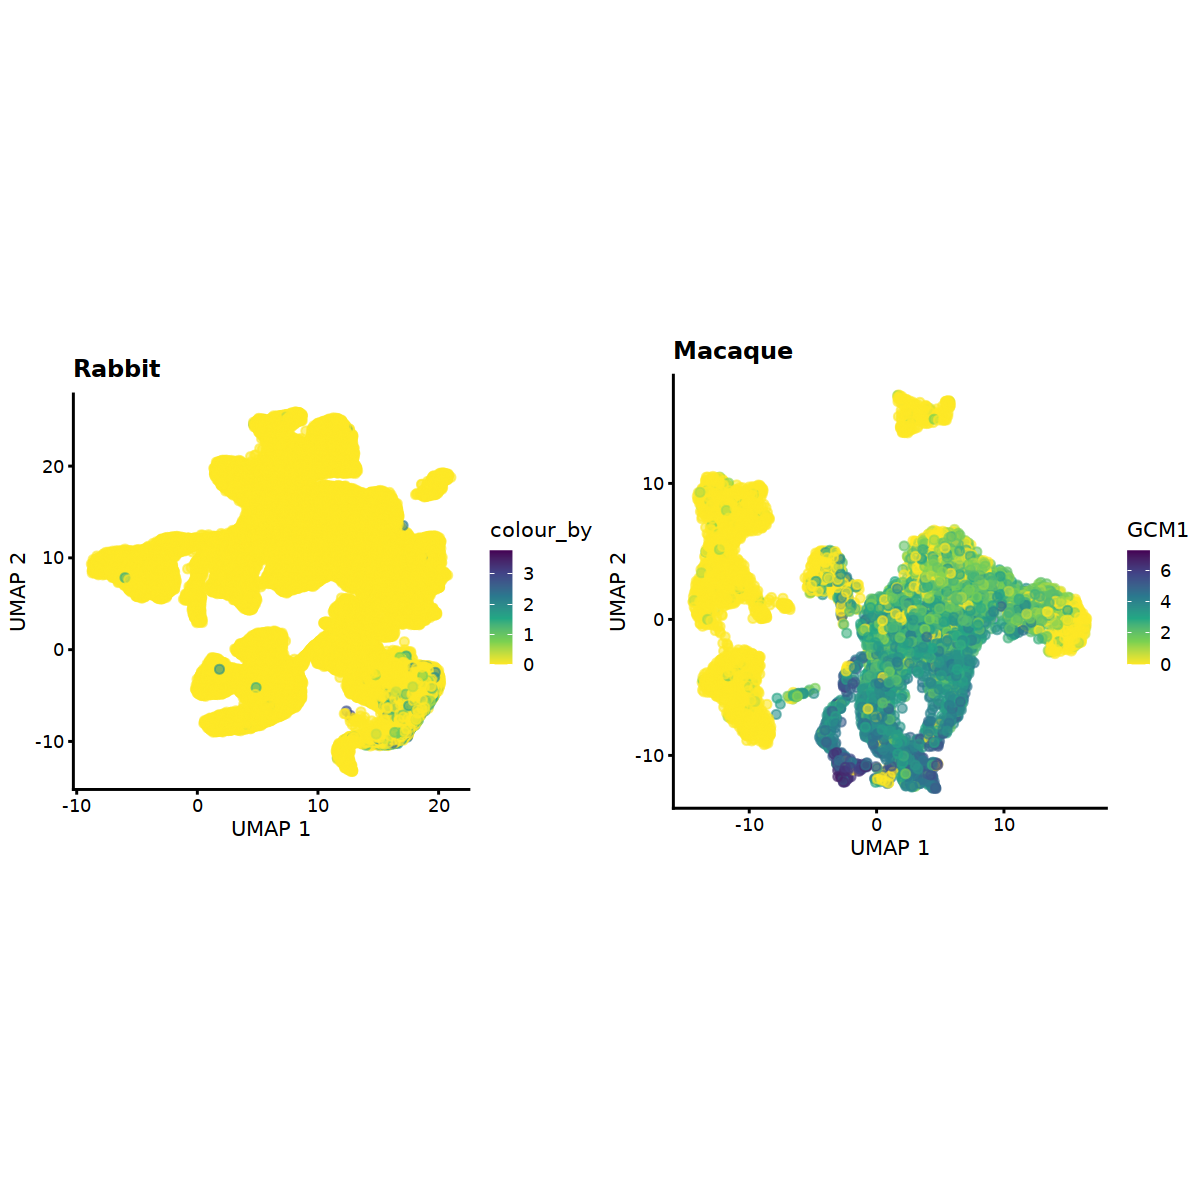

In [229]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
#ENSMFAG00000031381
#ENSMFAG00000024472
#ENSMFAG00000017477
#ENSMFAG00000004040
p2 <- plotReducedDim(mf_data,"UMAP", colour_by="ENSMFAG00000028616") + 
scale_colour_viridis_c(direction=-1,name="GCM1") + theme(aspect.ratio=1) + ggtitle("Macaque")

p1 <- plotReducedDim(r_data,"UMAP", colour_by="GCM1") + 
scale_colour_viridis_c(direction=-1) + theme(aspect.ratio=1) + ggtitle("Rabbit")

grid.arrange(p1,p2,nrow=1)


In [191]:
sr_markers <- metadata(mf_predict_ocmm$orig.results$oc)$de.genes

In [ ]:
empirical.markers <- scran::findMarkers(mf_data, mf_data$predicted_celltype, direction="up")

In [217]:
mf_genes <- rowData(mf_data)
rownames(mf_genes) <- mf_genes[,1]

sr_markers <- metadata(mf_predict_ocmm$orig.results$oc)$de.genes

genes <- vector()
for(ct in unique(mf_data$predicted_celltype)) {
    markers <- unique(unlist(sr_markers[[ct]]))
    markers <- mf_genes[markers,"gene_name"]
    m <- match(markers, rownames(empirical.markers[[ct]]))
    m <- beta.markers[rank(m) <= 1]
    genes <- c(genes, m)
}



In [218]:
genes

[1] "SEPHS1"             "ZC3H8"              "SFRP2"             
 [4] "RAB25"              "BUB1"               "ACADL"             
 [7] "ENSMFAG00000003238" "YWHAZ"              "SFRP2"             
[10] "ENSMFAG00000000034" "ENSMFAG00000041709" "SPINT2"            
[13] "TUBB2B"             "FAT1"               "FOXH1"             
[16] "FNDC4"              "ENSMFAG00000045733" "RPLP1"             
[19] "CCNB2"              "HOOK1"              "UBA2"              
[22] "FST"                "PPIB"               "ENSMFAG00000002478"
[25] "NT5DC2"             "KDM5B"              "APPL1"             
[28] "ENSMFAG00000002474" "NME2"               "KDM5A"             
[31] "SPIN1"              "NME2"               "CCDC39"            
[34] "ENSMFAG00000043037" "ZMYND8"             "HESX1"             
[37] "ENSMFAG00000042464" "ENSMFAG00000002478" "EPCAM"             
[40] "ESRP1"              "HSPA9"              "TMBIM6"            
[43] "PHF14"              "EOMES"              "ENSMFAG00000002573"
[46] "AURKA"              "SBNO1"              "GJA1"              
[49] "GALNT1"             "ZMYND8"             "ENSMFAG00000001955"

In [235]:
test<-mf_genes[ocmm_train_mf$oc$common.genes,"gene_name"]

In [244]:
hm.exp <- scrabbitr::getMeanExpression(mf_data,test[1:50] ,group_by="predicted_celltype", norm="min-max")
hm.exp <- hm.exp[complete.cases(hm.exp), ]


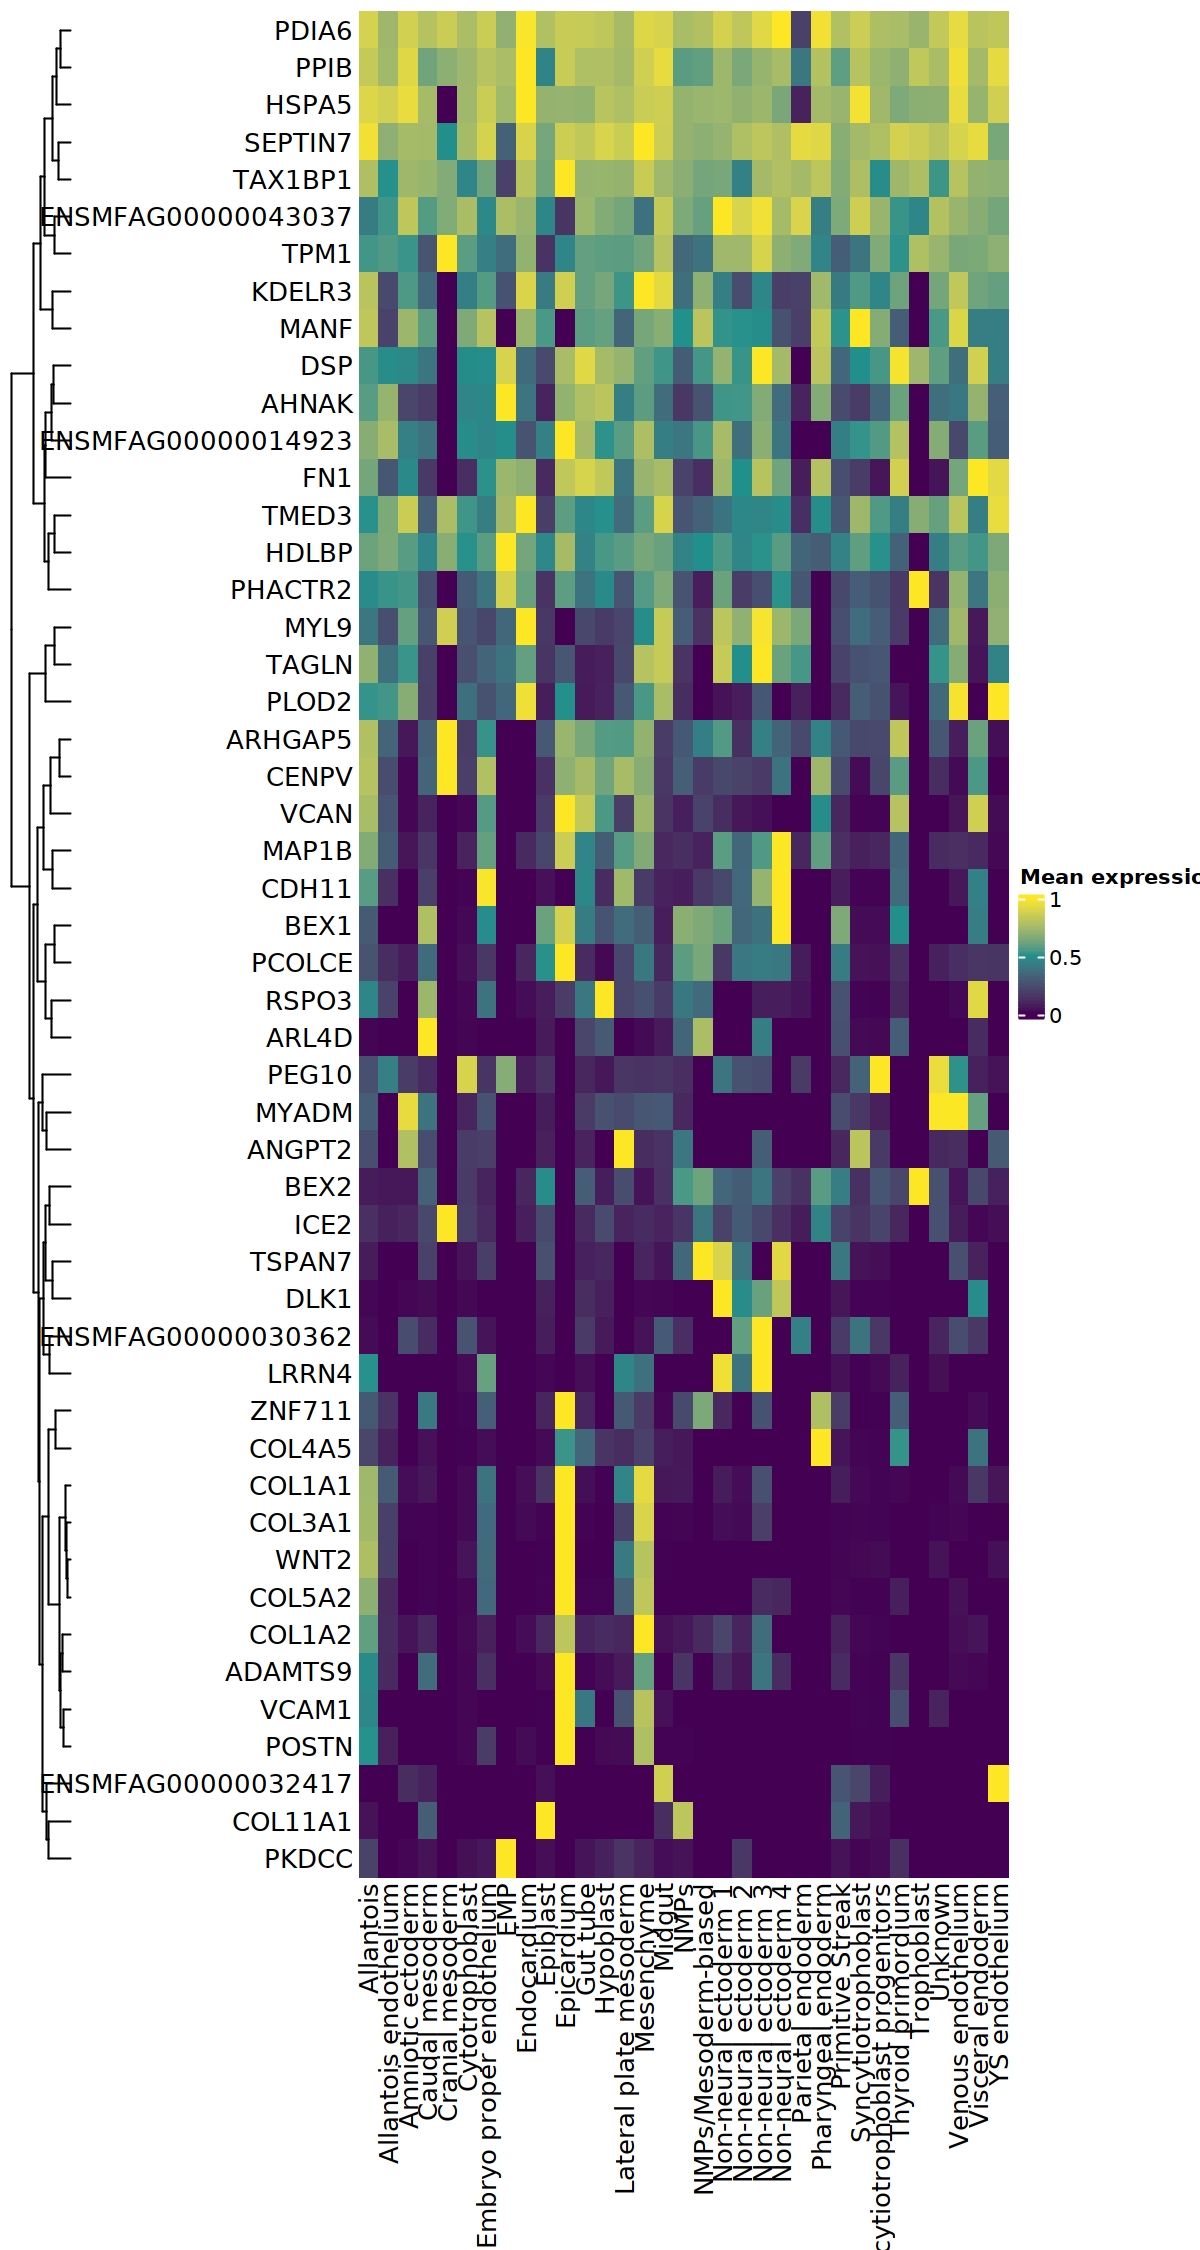

In [245]:
options(repr.plot.width = 8, repr.plot.height = 15, repr.plot.res = 150)
Heatmap(hm.exp,
        name = "Mean expression",
        cluster_rows = T,
        cluster_columns = F,
        cluster_row_slices = F,
        row_names_side = "left",
        row_labels = rownames(hm.exp),
        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))

In [83]:
library(ComplexHeatmap)
library(viridis)

Loading required package: viridisLite



In [34]:
grep("28616",rowData(mf_data)[,1],value=TRUE)

[1] "ENSMFAG00000028616"

In [35]:
rowData(mf_data)["ENSMFAG00000028616",]

DataFrame with 1 row and 2 columns
                           ensembl_id          gene_name
                          <character>        <character>
ENSMFAG00000028616 ENSMFAG00000028616 ENSMFAG00000028616

In [27]:
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

## Predicting cell types in human

### Training on mouse

In [623]:
# Train SingleR
rownames(m_data) <- rowData(m_data)[,"ensembl_id"]
m_temp <- m_data[mm_hs_one2one$mm,]
rownames(m_temp) <- mm_hs_one2one$hs

mm_train_hs <- trainSingleR(ref = m_temp, 
                labels = m_data$celltype,
                de.method = "wilcox",
                de.n = 50,
                aggr.ref = TRUE)
saveRDS(mm_train_hs,paste0(out_path,"mm_train_hs.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


In [626]:
hs_predict_mm <- classifySingleR(test = hs_data[mm_hs_one2one$hs,],
                                 trained = mm_train_hs)
saveRDS(hs_predict_mm,paste0(out_path,"hs_predict_mm.rds"))

### Training on mouse and rabbit data

In [51]:
# Get one-to-one orthologs across species
oc_mm_hs_one2one <- merge(oc_hs_one2one, mm_hs_one2one,by="hs")
head(oc_mm_hs_one2one)

hs      oc                 mm                
1 A1BG    ENSOCUG00000010122 ENSMUSG00000022347
2 A1CF    ENSOCUG00000011587 ENSMUSG00000052595
3 A2M     ENSOCUG00000006029 ENSMUSG00000030111
4 A3GALT2 ENSOCUG00000012461 ENSMUSG00000028794
5 A4GALT  ENSOCUG00000006673 ENSMUSG00000047878
6 A4GNT   ENSOCUG00000004002 ENSMUSG00000037953

In [11]:
# Prepare data
r_temp <- r_data[oc_mm_hs_one2one$oc,]
rownames(r_temp) <- oc_mm_hs_one2one$hs

m_temp <- m_data[oc_mm_hs_one2one$mm,]
rownames(m_temp) <- oc_mm_hs_one2one$hs

In [12]:
# Train SingleR
ocmm_train_hs <- trainSingleR(ref = list(oc=r_temp, mm=m_temp), 
    labels = list(r_data$celltype, m_data$celltype),
                             de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)
saveRDS(ocmm_train_hs,paste0(out_path,"oc_mm_train_hs.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 itera

In [40]:
ocmm_train_hs <- readRDS(paste0(out_path,"oc_mm_train_hs.rds"))

In [110]:
oc_train_hs <- readRDS(paste0(out_path,"oc_train_hs.rds"))

In [52]:
hs_predict_ocmm <- classifySingleR(test = hs_data[oc_mm_hs_one2one$hs,],
                                 trained = ocmm_train_hs)

#saveRDS(hs_predict_ocmm,paste0(out_path,"hs_predict_ocmm_train.rds"))

### Explore predictions

In [33]:
hs_predict_ocmm <- readRDS(paste0(out_path,"hs_predict_ocmm_train.rds"))

In [2]:
hs_predict_oc <- readRDS(paste0(out_path,"hs_predict_oc_train.rds"))

In [5]:
hs_predict_mm <- readRDS(paste0(out_path,"hs_predict_mm.rds"))

In [12]:
calcEuclidean <- function(x1,y1,x2,y2) (x1-y1)**2 + (x2-y2)**2

plotAnnotatedUMAP <- function(sce, colour_by="predicted_celltype", ncell_filt=5,size=1,
                              label_force=15,
                              palette=scrabbitr::celltype_colours) {
    
    col_data <- as.data.frame(colData(sce))
    col_data$group <- col_data[[colour_by]]
    
    umap_df <- as.data.frame(reducedDim(sce,"UMAP"))
    colnames(umap_df) <- c("UMAP_1","UMAP_2")
    col_data <- cbind(col_data, umap_df)
    
    # Get mean position for each group
    mean_data <- col_data %>% group_by(group) %>% summarize_at(.vars = vars(UMAP_1,UMAP_2),.funs = c("mean")) 
    mean_data <- as.data.frame(mean_data[complete.cases(mean_data),])
    rownames(mean_data) <- mean_data$group

    # Get position of closest cell to group mean
    label_pos <- col_data %>% group_by(group) %>%  filter(
        calcEuclidean(UMAP_1, mean_data[group,"UMAP_1"], UMAP_2, mean_data[group,"UMAP_2"]) == 
        min(calcEuclidean(UMAP_1, mean_data[group,"UMAP_1"], UMAP_2, mean_data[group,"UMAP_2"]))) 

     # Filter annotations with less than ncell_filt cells
    freqs <- table(sce[[colour_by]])
    label_pos <- label_pos[label_pos$group %in% names(freqs[freqs > ncell_filt]),]
    
    # Repels labels from rest of points
    col_data$group <- "" 
    label_pos <- rbind(label_pos, col_data)
    
    # Wrap long labels
    label_pos$group_wrapped <- stringr::str_wrap(label_pos$group , width = 10)
    
    p <- ggplot(col_data, aes_string(x="UMAP_1",y="UMAP_2",colour=colour_by)) + 
        ggrastr::geom_point_rast(size=size) + 
        geom_text_repel(data=label_pos, aes(x=UMAP_1, y=UMAP_2,label=group_wrapped,segment.colour=group),color="black",
               min.segment.length = 0,box.padding = 0.5,max.overlaps=Inf,size=4,force=label_force) + 
        coord_cartesian(clip = "off") +
        scale_colour_manual(aesthetics=c("color","segment.colour"),values=palette[sce[[colour_by]]],drop=TRUE,
                   breaks=names(freqs[freqs > ncell_filt])) + 

        theme_void()+
        theme(legend.position="none")
    
    return(p)
    
    
}

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

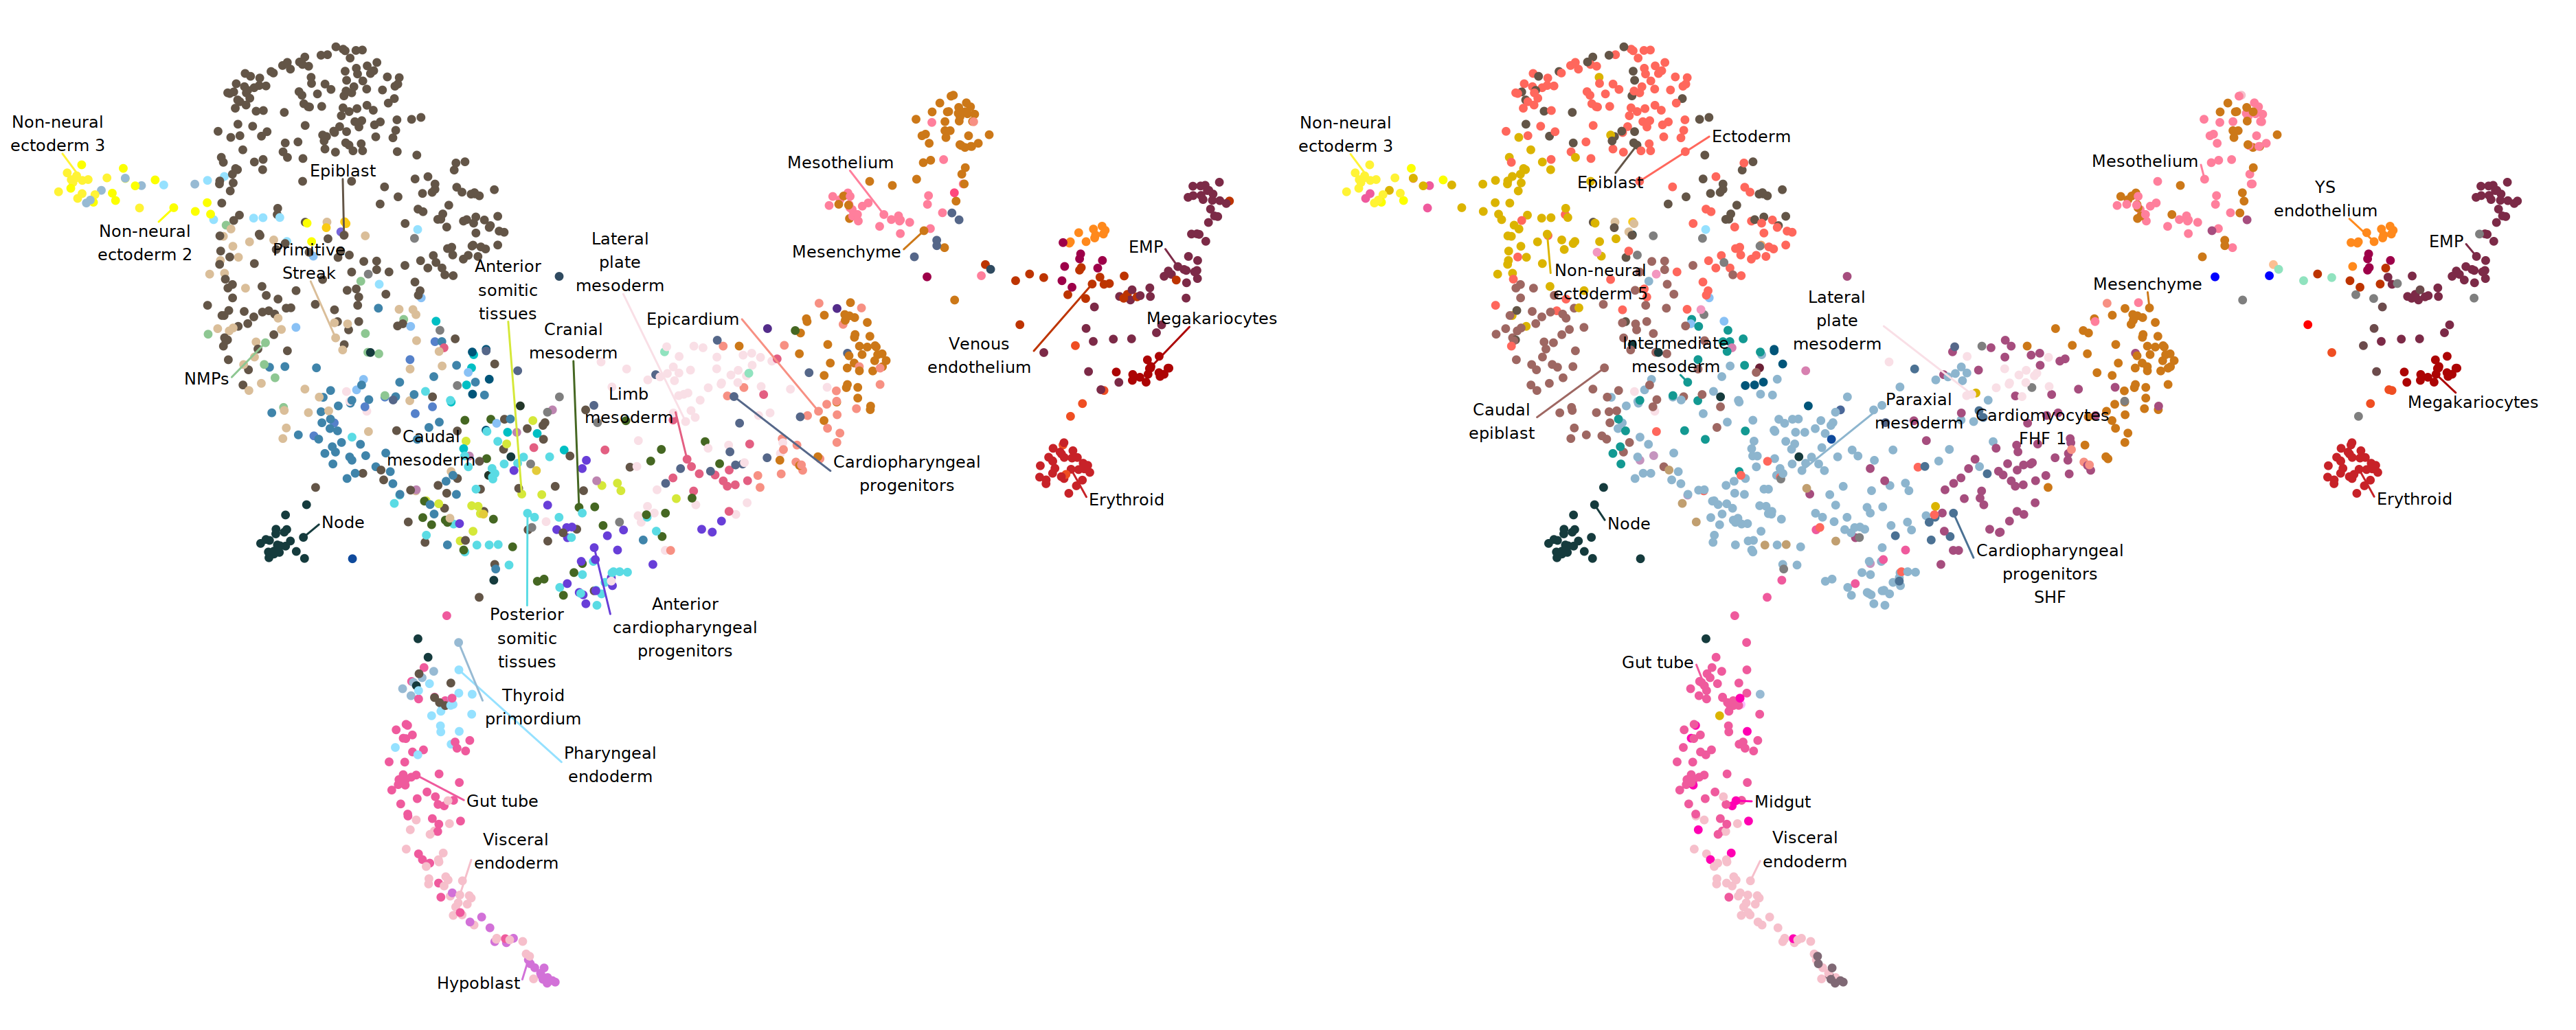

In [25]:
options(repr.plot.width = 25, repr.plot.height = 10, repr.plot.res = 150)

hs_data$oc_predicted <- hs_predict_oc$pruned.labels
hs_data$mm_predicted <- hs_predict_mm$pruned.labels

p1 <- plotAnnotatedUMAP(hs_data,"oc_predicted",ncell_filt=10,size=2,label_force=20)
p2 <- plotAnnotatedUMAP(hs_data,"mm_predicted",ncell_filt=10,size=2,label_force=18)
p <- grid.arrange(p1,p2,nrow=1)
p
ggsave("../plots/predict_celltypes/hs_predicted_train_comparison.pdf",p,width=25,height=10,dpi=300)

In [291]:
ggsave("../plots/predict_celltypes/hs_original.pdf",p1,width=10,height=6)

In [6]:
write.csv(hs_predict_oc$pruned.labels, "../data-out/predict_celltypes/Tyser_2020/hs_predict_oc.tsv",sep="\t")

Warning message in write.csv(hs_predict_oc$pruned.labels, "../data-out/predict_celltypes/Tyser_2020/hs_predict_oc.tsv", :
“attempt to set 'sep' ignored”


Warning message:
“Removed 20 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11 rows containing missing values (geom_text_repel).”


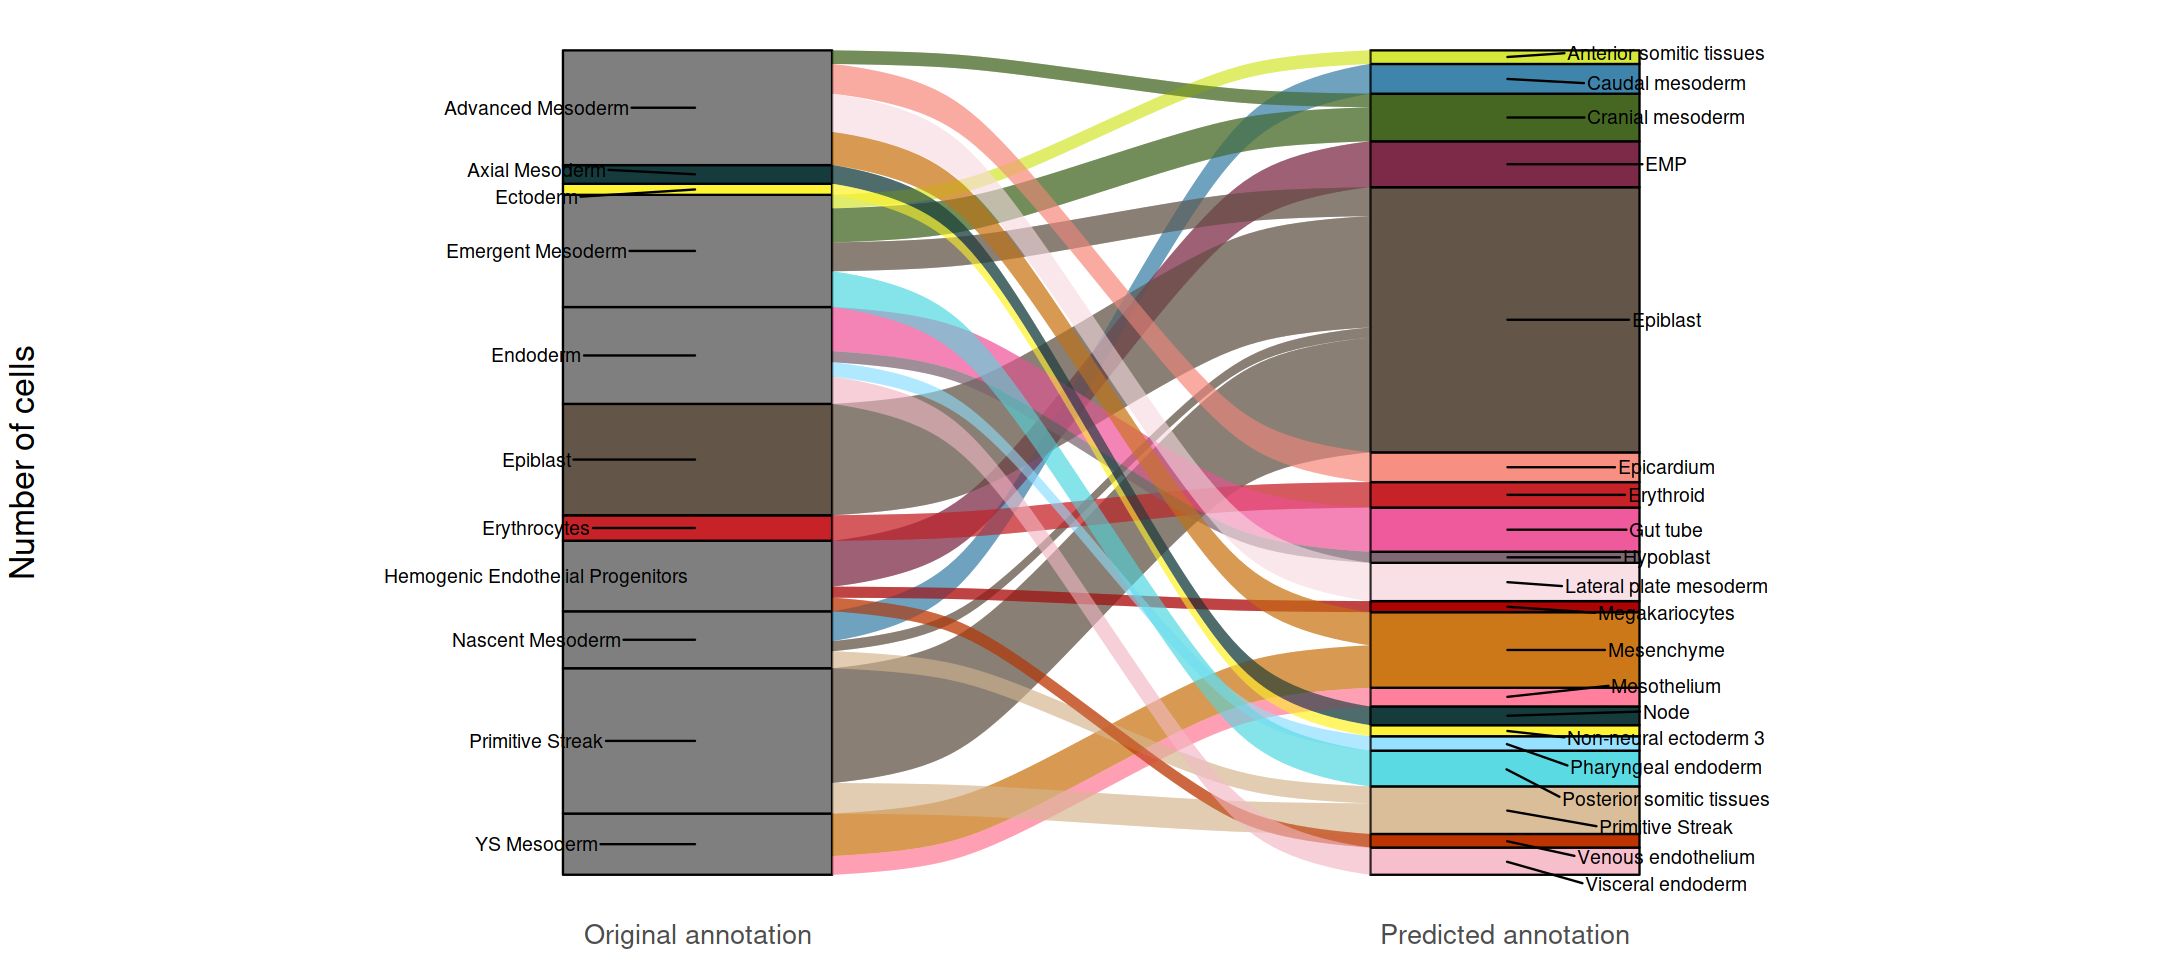

In [205]:
p <- scrabbitr::plotAnnotationAlluvium(hs_data,"celltype", "predicted_celltype")
p
#ggsave("../plots/predict_celltypes/Tyser_2020_alluvial.pdf",p,dpi=300, width=12, height=8)

TableGrob (1 x 4) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (1-1,4-4) arrange gtable[layout]

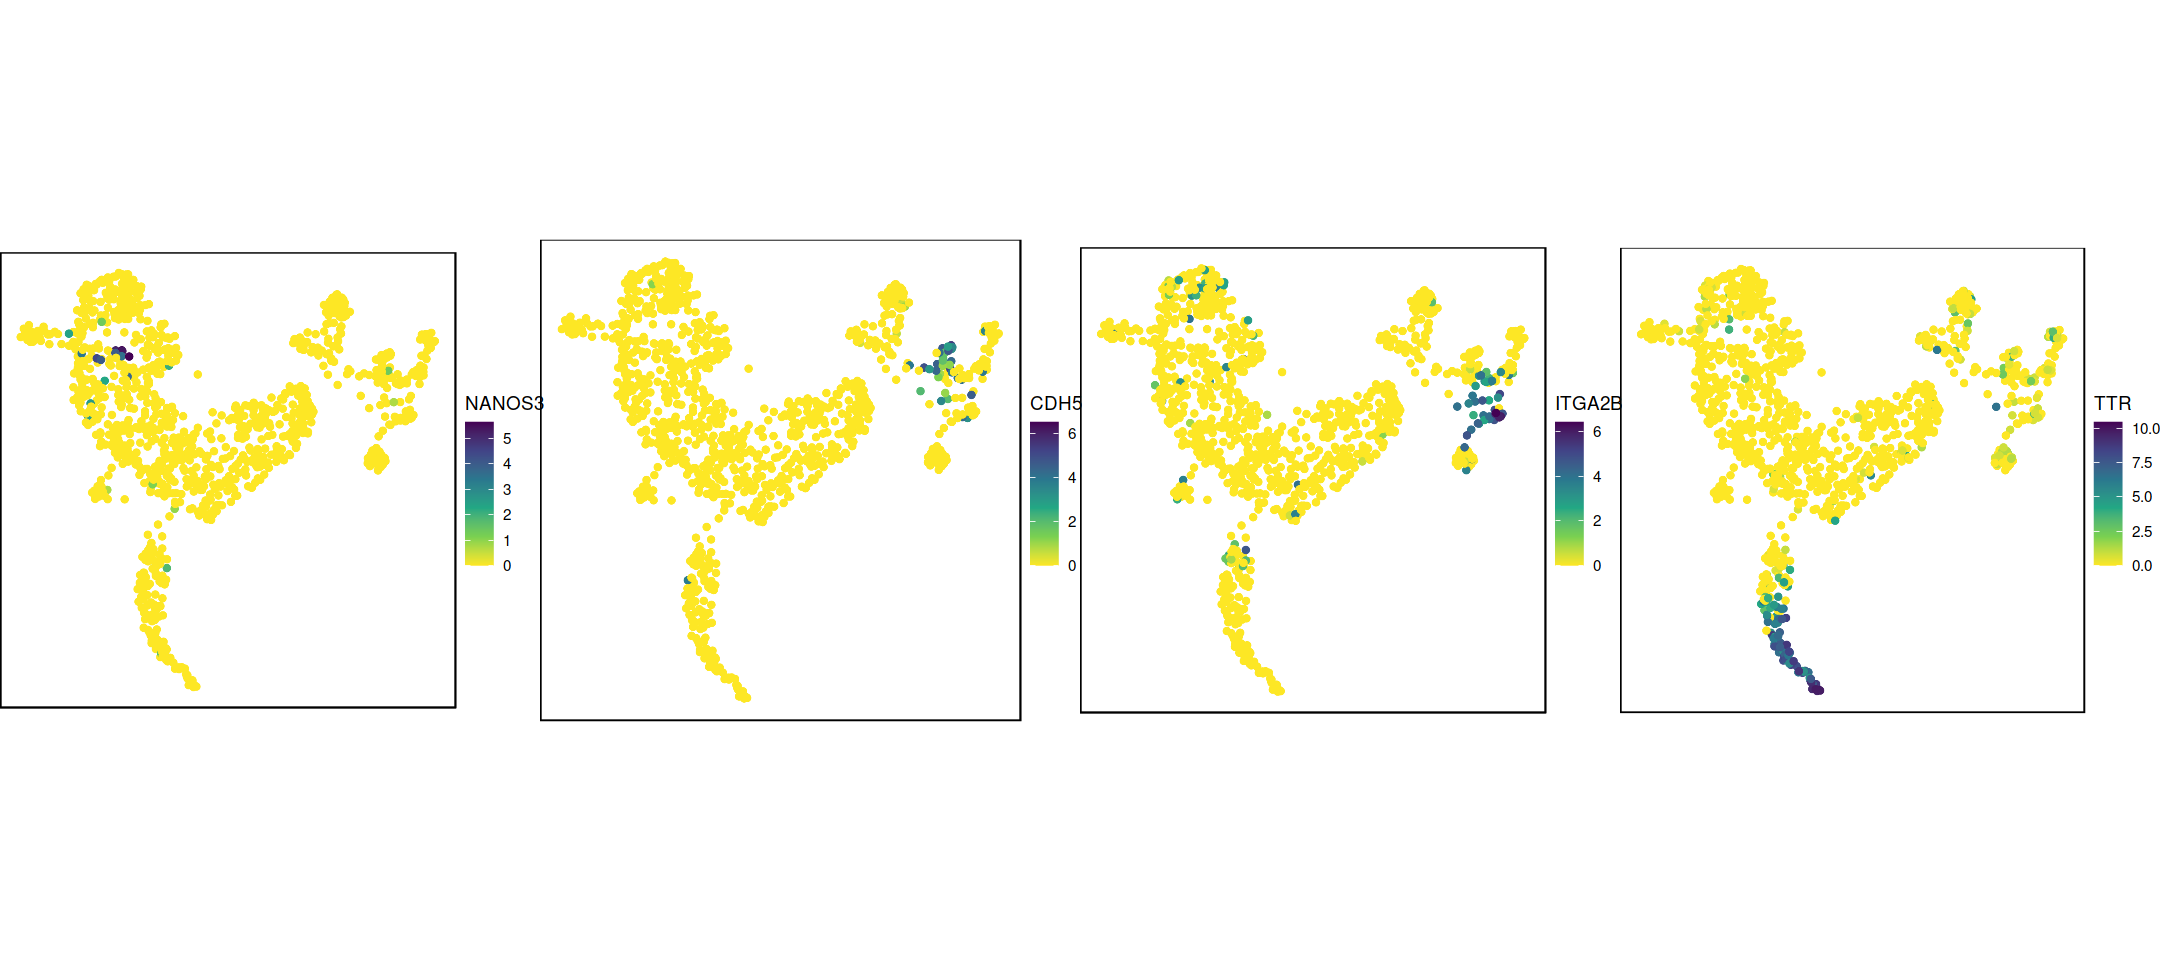

In [314]:
p1 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="CDH5")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="CDH5") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 

p2 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="ITGA2B")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="ITGA2B") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 

p3 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="TTR")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="TTR") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 
p4 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="NANOS3")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="NANOS3") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 

p <- grid.arrange(p4,p1,p2,p3,nrow=1)
p
ggsave("../plots/predict_celltypes/Tyser_2020_markers.pdf",p,dpi=300, width=24, height=5)

List of length 4
names(4): common.genes original.exprs nn.indices search

In [ ]:
oc_train_hs$common.genes

In [117]:
head(oc_hs_one2one)

oc                 hs    
1 ENSOCUG00000000006 INPP1 
2 ENSOCUG00000000007 GLIPR2
3 ENSOCUG00000000008 CCIN  
4 ENSOCUG00000000009 CLTA  
5 ENSOCUG00000000010 GNE   
6 ENSOCUG00000000012 HADHB

In [128]:
hs_model_genes <- oc_hs_one2one[oc_hs_one2one$oc %in% oc_train_hs$common.genes,"oc"]

### Find genes predictive of cell types

In [662]:
# Load marker genes
r_markers <- readRDS("../data-out/compare_genes/r_markers_up_all.rds")
m_markers <- readRDS("../data-out/compare_genes/m_markers_up_all.rds")

In [811]:
test <- metadata(hs_predict_mm)$de.genes

In [828]:
#r_query <- test$Ectoderm$Epiblast
r_query <- test$Epiblast$Ectoderm

In [756]:
model_genes.ID <- metadata(hs_predict_oc)$common.genes
model_genes <- r_genes[r_genes$ensembl_id %in% model_genes.ID,"gene_name"]

In [755]:
# Temp utility function
.getGenesOCMMHS <- function(r_query) {
    r_queryID <- r_genes[r_genes$gene_name %in% r_query,"ensembl_id"]

    # Check one-to-one orthologs present across all species
    r_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "oc"]
    m_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "mm"]
    hs_query <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "hs"]

    # Convert to gene names
    rownames(r_genes) <- r_genes$ensembl_id
    r_query <- r_genes[r_queryID,"gene_name"]

    rownames(m_genes) <- m_genes$ensembl_id
    m_query <-  m_genes[m_queryID,"gene_name"]
    
    return(list(r_query = r_query, m_query=m_query, hs_query=hs_query))

}

In [781]:
.plotGenesOCMMHS <- function(r_exp,m_exp,hs_exp,celltype,preserve_order=FALSE) {
    p1 <- Heatmap(r_exp,
        name = "Mean expression",
        row_labels = rownames(r_exp),
        cluster_rows=!preserve_order,
        column_split = colnames(r_exp) != celltype,
        column_gap = unit(0.5, "cm"),

        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))

    p2 <- Heatmap(m_exp,
            name = "Mean expression",
            row_labels = rownames(m_exp),
            cluster_rows=!preserve_order,
            column_split = colnames(m_exp) != celltype,
                  column_gap = unit(0.5, "cm"),
            col=circlize::colorRamp2(c(0,0.5,1),
                                     viridis(3,option="D")))

    p3 <- Heatmap(hs_exp,
            name = "Mean expression",
            row_labels = rownames(hs_exp),
            cluster_rows=!preserve_order,
            column_split = colnames(hs_exp) != celltype,
                  column_gap = unit(0.5, "cm"),
            col=circlize::colorRamp2(c(0,0.5,1),
                                     viridis(3,option="D")))


    p <- p1 + p2 + p3
    draw(p, ht_gap = unit(2, "cm"))
    
}

In [795]:
celltype <- "Epiblast"
markers <- rownames(r_markers[[celltype]])[r_markers[[celltype]]$p.value < 0.05]
r_query <- model_genes[match(markers, model_genes,nomatch=0)]

In [829]:
query <- .getGenesOCMMHS(r_query)
r_exp <- scrabbitr::getMeanExpression(r_data, query[[1]] ,group_by="celltype", norm="min-max")
m_exp <- scrabbitr::getMeanExpression(m_data, query[[2]] ,group_by="celltype", norm="min-max")
hs_exp <- scrabbitr::getMeanExpression(hs_data, query[[3]] ,group_by="oc_predicted", norm="min-max")

In [822]:
hs_exp <- scrabbitr::getMeanExpression(hs_data, query[[3]] ,group_by="celltype", norm="min-max")

In [830]:
options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 300)
.plotGenesOCMMHS(r_exp, m_exp, hs_exp,celltype="Epiblast")

Warning message:
“Heatmap/annotation names are duplicated: Mean expression”
Warning message:
“Heatmap/annotation names are duplicated: Mean expression, Mean
expression”


In [798]:
# Find genes enriched in rabbit and human not in mouse
N <- 5
total_exp <- r_exp[,"PGC"] + hs_exp[,"PGC"] - m_exp[,"PGC"]
r_query <- names(total_exp[order(total_exp,decreasing=TRUE)])[1:10]
r_query

[1] "HPRT1"              "WNK3"               "UPP1"              
 [4] "ENSOCUG00000023527" "NRN1L"              "SNRPN"             
 [7] "RETREG1"            "KDM5B"              "NVL"               
[10] "SCG3"

In [799]:
query <- .getGenesOCMMHS(r_query)
r_exp <- scrabbitr::getMeanExpression(r_data, query[[1]] ,group_by="celltype", norm="min-max")
m_exp <- scrabbitr::getMeanExpression(m_data, query[[2]] ,group_by="celltype", norm="min-max")
hs_exp <- scrabbitr::getMeanExpression(hs_data, query[[3]] ,group_by="oc_predicted", norm="min-max")

options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 300)
.plotGenesOCMMHS(r_exp, m_exp, hs_exp,celltype=celltype)

Warning message:
“Heatmap/annotation names are duplicated: Mean expression”
Warning message:
“Heatmap/annotation names are duplicated: Mean expression, Mean
expression”


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



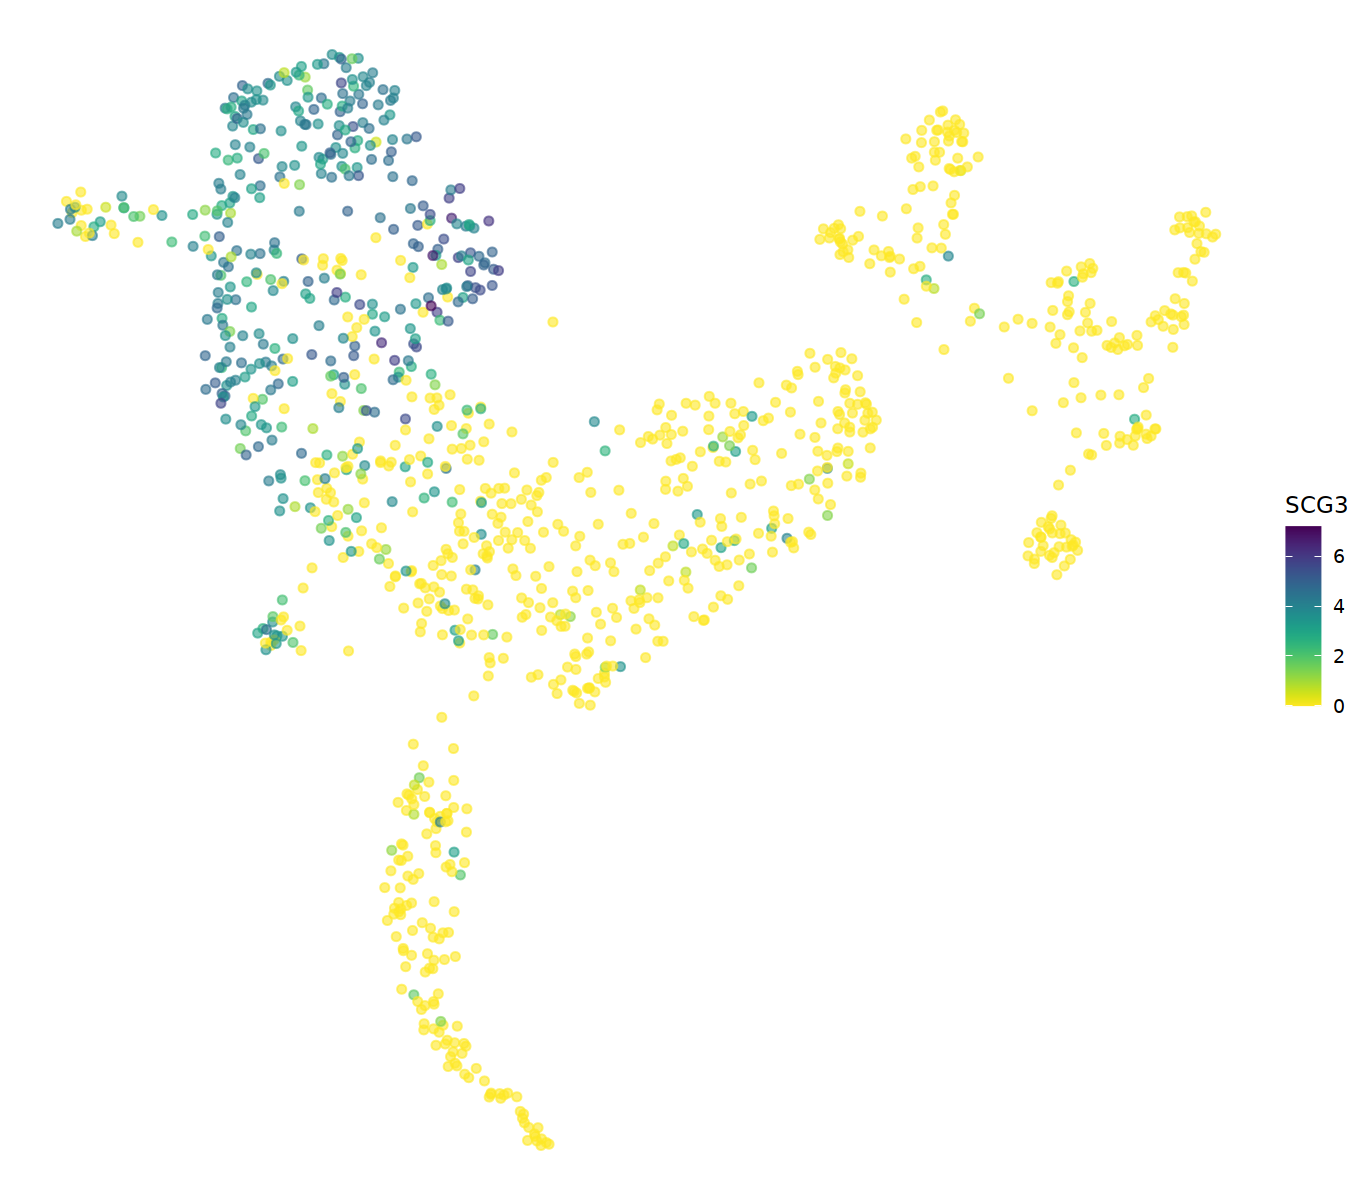

In [805]:
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 150)
i <- 6
plotReducedDim(hs_data,"UMAP", colour_by=query[[3]][i]) + scale_color_viridis(direction=-1,name=query[[3]][i]) + theme_void()

In [736]:
m_query

[1] "1700067K01Rik" "Ccpg1"         "Cnmd"          "Ddit4l"       
 [5] "Kit"           "Krtcap3"       "Mkrn1"         "Mrpl15"       
 [9] "Nanos3"        "Pcsk1n"        "Pou5f1"        "Pou5f1"       
[13] "Rest"          "Sox15"         "Usp48"         "Zfp296"

In [749]:
#rownames(m_data) <- m_genes[,"gene_name"]

r_pgc.exp <- scrabbitr::getMeanExpression(r_data, r_query ,group_by="celltype", norm="min-max")
m_pgc.exp <- scrabbitr::getMeanExpression(m_data, m_query ,group_by="celltype", norm="min-max")
hs_pgc.exp <- scrabbitr::getMeanExpression(hs_data, hs_query ,group_by="oc_predicted", norm="min-max")

In [750]:
options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 300)

p1 <- Heatmap(r_pgc.exp,
        name = "Mean expression",
        row_labels = rownames(r_pgc.exp),
        column_split = colnames(r_pgc.exp) != celltype,
        column_gap = unit(0.5, "cm"),

        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))

p2 <- Heatmap(m_pgc.exp,
        name = "Mean expression",
        row_labels = rownames(m_pgc.exp),
        column_split = colnames(m_pgc.exp) != celltype,
              column_gap = unit(0.5, "cm"),
        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))

p3 <- Heatmap(hs_pgc.exp,
        name = "Mean expression",
        row_labels = rownames(hs_pgc.exp),
        column_split = colnames(hs_pgc.exp) != celltype,
              column_gap = unit(0.5, "cm"),
        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))


p <- p1 + p2 + p3
draw(p, ht_gap = unit(2, "cm"))

Warning message:
“Heatmap/annotation names are duplicated: Mean expression”
Warning message:
“Heatmap/annotation names are duplicated: Mean expression, Mean
expression”


[1] "KIT"                "NANOS3"             "ENSOCUG00000029659"
 [4] "ENSOCUG00000013268" "DDIT4L"             "ENSOCUG00000001387"
 [7] "TFAP2C"             "PCSK1N"             "SOX15"             
[10] "ENSOCUG00000027435"

In [734]:
r_queryID <- r_genes[r_genes$gene_name %in% r_query,"ensembl_id"]

# Check one-to-one orthologs present across all species
r_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "oc"]
m_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "mm"]
hs_query <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "hs"]

# Convert to gene names
rownames(r_genes) <- r_genes$ensembl_id
r_query <- r_genes[r_queryID,"gene_name"]

rownames(m_genes) <- m_genes$ensembl_id
m_query <-  m_genes[m_queryID,"gene_name"]

In [705]:
r_query

[1] "C19orf67" "CCPG1"    "CNMD"     "DDIT4L"   "KIT"      "KRTCAP3" 
 [7] "MKRN1"    "MRPL15"   "NANOS3"   "PCSK1N"   "POU5F1"   "POU5F1"  
[13] "REST"     "SOX15"    "USP48"    "ZNF296"

In [679]:
m_query

[1] "Ace2"          "Acss3"         "Adora2b"       "Ak4"          
 [5] "Ap3b2"         "Atf7ip"        "Atp10a"        "Atp4a"        
 [9] "Atp6v0b"       "Atpaf2"        "Atpaf2"        "1700067K01Rik"
[13] "Cartpt"        "Ccl7"          "Ccpg1"         "Cdkl5"        
[17] "Cldn19"        "Cnmd"          "Cox7a2l"       "Cpeb1"        
[21] "Ctsh"          "Ddit4l"        "Diaph2"        "Dpp6"         
[25] "Dusp4"         "Eno2"          "Foxa3"         "Gjb3"         
[29] "Hbp1"          "Il13ra1"       "Itga2"         "Jmjd1c"       
[33] "Kit"           "Krtcap3"       "Lactb2"        "Lpcat4"       
[37] "Ly6g6c"        "Madcam1"       "Man1a"         "Map4k4"       
[41] "Mcur1"         "Mfge8"         "Mkrn1"         "Mphosph8"     
[45] "Mrpl15"        "Msh6"          "Nanos3"        "Nop10"        
[49] "Pcmtd1"        "Pcsk1n"        "Pld3"          "Pou5f1"       
[53] "Pou5f1"        "Prdm1"         "Pygl"          "Rab6b"        
[57] "Rab7"          "Rbm46"         "Rbpj"          "Rest"         
[61] "Rps11"         "Rps20"         "Rps4x"         "Rps5"         
[65] "Sav1"          "Sel1l3"        "Serinc3"       "Serpini1"     
[69] "Slc25a5"       "Slc7a3"        "Smpdl3b"       "Sox15"        
[73] "Spon1"         "Syndig1"       "Tdrkh"         "Tfap2c"       
[77] "Timm8a1"       "Tmem92"        "Ttll7"         "Uap1"         
[81] "Ubap2"         "Ube2h"         "Usp48"         "Zfp296"

In [648]:
celltype <- "Epiblast"
r_query <- r_genes[r_genes$ensembl_id %in% unlist(unique(hs_de_genes[[celltype]])),"gene_name"]
hs_query <- oc_hs_one2one[oc_hs_one2one$oc %in% unlist(unique(hs_de_genes[[celltype]])),"hs"]

In [655]:
r_query <- r_genes[r_genes$ensembl_id %in%  metadata(hs_predict_oc)$common.genes[1:200],"gene_name"]
hs_query <- oc_hs_one2one[oc_hs_one2one$oc %in%  metadata(hs_predict_oc)$common.genes[1:200],"hs"]

In [656]:
hm.exp <- scrabbitr::getMeanExpression(hs_data,hs_query ,group_by="celltype", norm="min-max")
hm.exp <- hm.exp[complete.cases(hm.exp), ]


In [258]:
#PGC
r_query <- c("NANOS3", "PCSK1N", "CPEB1", "GDF3", "C19orf67", "DHDH", "PYY", "FRMD6", "KIT", "ETV4", "SFRP2", "WNT5B",
"CNMD", "TDRKH", "UBAP2", "CD9", "ITGA6", "SERPINI1", "MAP7", "TEXT264", "CCPG1")

#Epiblast
r_query <- c("USP44", "DNMT3B", "VRTN", "SFRP2", "RRAGD", "DPYSL5", "CRYGD", "TUBA4A", "GNG3", "TNFAIP6", "FGFR1", "KRTCAP3", "OSER1", "RBPMS2", "HOOK1", "FABP3", "RAB6B", "NRN1L")
r_queryID <- r_genes[r_genes$gene_name %in% r_query,"ensembl_id"]

# Check one-to-one orthologs present across all species
r_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "oc"]
m_queryID <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "mm"]
hs_query <- oc_mm_hs_one2one[oc_mm_hs_one2one$oc %in% r_queryID, "hs"]

# Convert to gene names
rownames(r_genes) <- r_genes$ensembl_id
r_query <- r_genes[r_queryID,"gene_name"]

rownames(m_genes) <- m_genes$ensembl_id
m_query <-  m_genes[m_queryID,"gene_name"]


In [ ]:
options(repr.plot.width = 15, repr.plot.height = 60, repr.plot.res = 150)
Heatmap(hm.exp,
        name = "Mean expression",
        cluster_rows = T,
        cluster_columns = F,
        cluster_row_slices = F,
        row_names_side = "left",
        row_labels = rownames(hm.exp),
        col=circlize::colorRamp2(c(0,0.5,1),
                                 viridis(3,option="D")))

In [206]:
head(oc_mm_hs_one2one)

hs      oc                 mm                
1 A1BG    ENSOCUG00000010122 ENSMUSG00000022347
2 A1CF    ENSOCUG00000011587 ENSMUSG00000052595
3 A2M     ENSOCUG00000006029 ENSMUSG00000030111
4 A3GALT2 ENSOCUG00000012461 ENSMUSG00000028794
5 A4GALT  ENSOCUG00000006673 ENSMUSG00000047878
6 A4GNT   ENSOCUG00000004002 ENSMUSG00000037953

In [235]:
# Create PGC factor
r_data$isPGC <- ifelse(r_data$celltype == "PGC", "PGC", "Other")
m_data$isPGC <- ifelse(m_data$celltype == "PGC", "PGC", "Other")
hs_data$isPGC <- ifelse(hs_data$predicted_celltype == "PGC", "PGC", "Other")

In [721]:
oc_hs_degs

[1] "C19orf67" "CCPG1"    "CNMD"     "DDIT4L"   "KIT"      "KRTCAP3" 
 [7] "MKRN1"    "MRPL15"   "NANOS3"   "PCSK1N"   "POU5F1"   "REST"    
[13] "SOX15"    "USP48"    "ZNF296"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



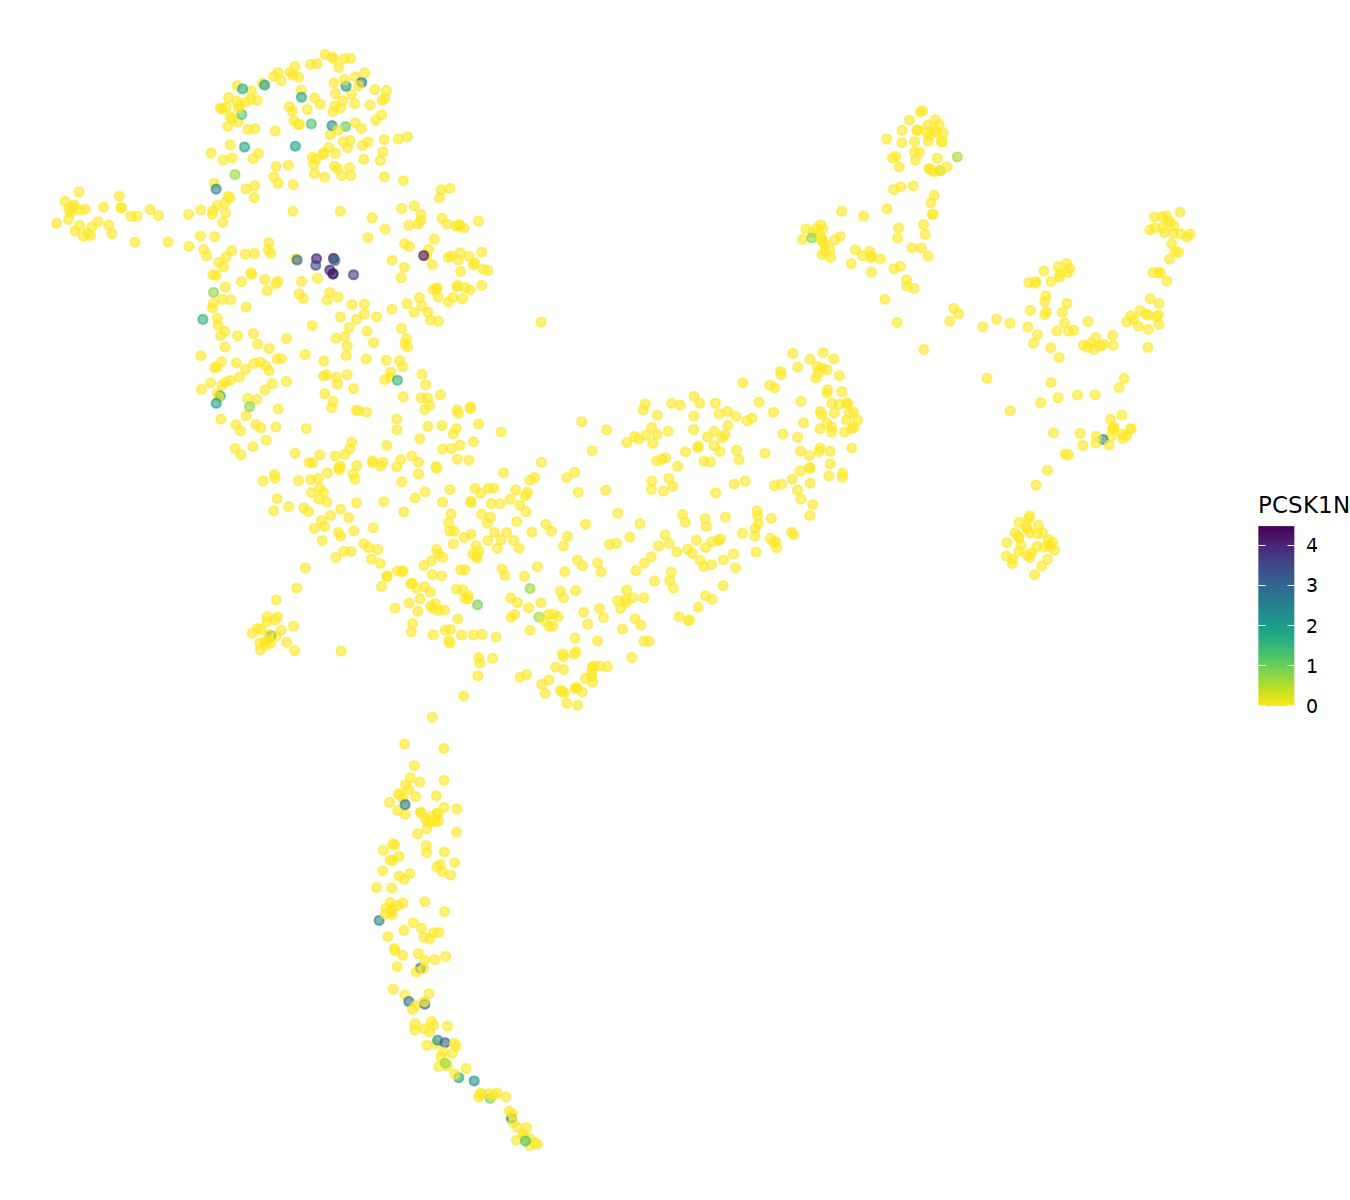

In [250]:
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 150)
plotReducedDim(hs_data,"UMAP", colour_by="PCSK1N") + scale_color_viridis(direction=-1,name="PCSK1N") + theme_void()